# Generating Paper Scorecard
**Author:** Marang Mutloatse

**Description:** This script generates a scorecard for the RISE dataset

**Version:** 0.0.1

**Status:** Development

## Import Libraries

In [118]:
import os

user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
import pandas as pd
import yaml
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
sys.path.insert(0,package_path + '/src/')
from hiv_support_package import visit_features,helper_functions,evaluation_metrics,model_validation
from sklearn.impute import SimpleImputer
from datetime import timedelta, date
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import *
from sklearn.model_selection import *
import sklearn
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from optbinning import Scorecard, BinningProcess
from optbinning.scorecard.plots import *
from optbinning.scorecard import ScorecardMonitoring
import mlflow
plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions

In [2]:
def one_hot_encode_col(df,dummies_col:str,prefix_entry:str):
    if df is not None:
        try:
            dummies = pd.get_dummies(df[dummies_col], prefix=prefix_entry,drop_first=False)
            df = df.join(dummies)
            return df
        except Exception as e:
            print(f"Exception on one hot encoding with error: {e}")

def correlation_measure(df, threshold=0.65):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

def add_IAS_stable_patient_col(df, months_col = 'V_EF_MONTHS_SINCE_FIRST_VISIT', vl_count_col = 'L_EF_VL_COUNT', rna_col = 'L_RESULTAB'):
    df['EC_IAS_STABLE']=0
    df.loc[((df[months_col]>=12)&(df[vl_count_col]>=2)
           &(df[rna_col]<1000)),'EC_IAS_STABLE'] =1
    return df


## Loading Data

In [3]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [4]:
input_root = config['rise_files']['raw_data_path']
uv_file = config['output_files']['unified_view_file']
start_date_iit = config['iit_inclusion_criteria']['iit_start_date']
last_date_iit = config['iit_inclusion_criteria']['iit_last_date']
uv_input = input_root + uv_file
print(uv_input)
print(start_date_iit)
print(last_date_iit)

/data/rise_data/unified_view.csv


In [5]:
%%time
df = pd.read_csv(uv_input,low_memory=False)

CPU times: user 35.7 s, sys: 2.49 s, total: 38.2 s
Wall time: 38.2 s


In [6]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 341 columns and 606136 rows.


## Dropping Columns with High Cardinality

In [7]:
# Dropping unnecessary columns
drop_some_cols = [
    "P_DATE_NEXT_CLINIC",
    "P_DATE_LAST_CLINIC",
    "V_PHARMACY_ID",
    "L_T_VL_SUPP_400",
    "L_T_VL_UNSUPP_400",
    "P_REGIMENTYPE",
    "L_LABORATORY_ID",
    "L_FACILITY_ID",
    "L_DATE_REPORTED",
    "L_DATE_COLLECTED",
    "P_PATIENT_ID",
    "P_DATE_NEXT_REFILL",
    "L_PATIENT_ID",
    "L_T_VL_UNSUPP_1000",
    "P_DATE_LAST_REFILL",
    "P_LAST_VIRAL_LOAD",
    "P_LAST_CD4",
    "P_LAST_CD4P",
    "P_REGIMEN",
    "P_DATE_CONFIRMED_HIV",
    "P_DATE_STARTED",
    "P_DATE_REGISTRATION",
    "P_DATE_BIRTH",
    "L_T_VL_UNDETECT_40",
    "E_EF_OTZ_STARTED",
    "E_PATIENT_ID",
    "E_DATE",
    "E_EF_FIRST_DATE_EAC",
    "E_EF_OTZ_STARTED",
    "C_CD4",
    "C_CD4P",
    "C_TB_STATUS",
    "C_BP",
    "C_EF_FIRST_DATE_VISIT",
    "C_EF_ID_SEQUENCE",
    "C_EF_DIFFERENT_LAST_FACILIITY",
    "C_EF_LAST_FACILITY_ID",   
]
df.drop(columns=drop_some_cols,inplace=True)

## Inclusion Criteria

In [8]:
df = df.sort_values(by=['V_PATIENT_ID','V_DATE_VISIT'])
# Filter date
df = df.loc[(df['EF_START_DATE_TREATMENT'] >= start_date_iit) & (df['V_DATE_VISIT'] <= last_date_iit)]
# Filter out for records that only have one occurrence
df = df[df['V_PATIENT_ID'].map(df['V_PATIENT_ID'].value_counts() > 1)]

In [9]:
# Status list to Exclude
current_status_list = [
"Known Death",
"Hiv+ Non Art",
"Hiv Exposed Status Unknown",
"Hiv Exposed Infant Status Unknown",
"Pre-Art Transfer Out",
"Hiv Exposed Infant Status Unknown","Died"]
df = df[~df['P_CURRENT_STATUS'].isin(current_status_list)]

In [10]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 266520 rows.


## UV encoding and binning

In [11]:
# Rounding Age and Time in treatment to closest digits
df['EF_AGE_AT_START'] = df['EF_AGE_AT_START'].astype(int)
df['EF_AGE_AT_VISIT'] = df['EF_AGE_AT_VISIT'].astype(int)
df['EF_TIME_IN_TREATMENT_MONTHS'] = round(df['EF_TIME_IN_TREATMENT_MONTHS'],2)

In [12]:
# Some cleaning and FE of date of visits
df['U_EF_FIRST_DATE_VISIT'] = df.groupby('V_PATIENT_ID')['V_DATE_VISIT'].transform('min')
df['U_EF_FIRST_DATE_VISIT'] = pd.to_datetime(df['U_EF_FIRST_DATE_VISIT'])
df['V_DATE_VISIT'] = pd.to_datetime(df['V_DATE_VISIT'])
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = ((df['V_DATE_VISIT'] - df['U_EF_FIRST_DATE_VISIT'])/np.timedelta64(1, 'M'))
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'].fillna(0).astype(int)

In [13]:
# Binning of Some of the  
df['U_EF_NUM_MISSED_MONTHS'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'] + 1 - df[['V_PATIENT_ID','V_DATE_VISIT']].groupby('V_PATIENT_ID').cumcount()
df['EF_V_DURATION_CAT'] = pd.cut(df['V_DURATION'],bins = [0,60,120,1800],labels=['(0-60)DAYS','(2-4)MONTHS','(>6)MONTHS'],include_lowest=True)
df['P_EF_CURRENT_AGE_CAT'] = pd.cut(df['P_EF_CURRENT_AGE'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_AGE_AT_VISIT_CAT'] = pd.cut(df['EF_AGE_AT_VISIT'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = pd.cut(df['EF_TIME_IN_TREATMENT_MONTHS'],bins = [0,3,6,12,24,60],labels=['0-3months','3-6months','6-12months','1-2years','>2years'],include_lowest=True)

## Encoding on UV

In [14]:
lga_vals = df['P_EF_LGA_RESIDENCE'].value_counts(normalize=True).head(36).index.tolist()
df.loc[~df["P_EF_LGA_RESIDENCE"].isin(lga_vals), "P_EF_LGA_RESIDENCE"] = "Other"
df['U_EF_IS_LGA_FACILITY_RESIDENCE_SAME'] = np.where(df['V_L.G.A']==df['P_EF_LGA_RESIDENCE'], 
                                           1, 0)

In [15]:
# One hot encoding
df = one_hot_encode_col(df,'EF_AGE_AT_VISIT_CAT','EF_AGE_AT_VISIT_')
df = one_hot_encode_col(df,'EF_V_DURATION_CAT','EF_DURATION_')
df = one_hot_encode_col(df,'EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES','EF_TIME_TREATMENT_')
df = one_hot_encode_col(df,'S_CURRENT_STATUS','S_CURRENT_STATUS_')
# Label Encoding LGA residence
le = LabelEncoder()
df['P_EF_LGA_RESIDENCE'] = le.fit_transform(df['P_EF_LGA_RESIDENCE'])
df['V_L.G.A'] = le.fit_transform(df['V_L.G.A'])

In [16]:
# Push to Lists to ease imputation
cols_labs = df.columns[df.columns.str.startswith('L_')].to_list()
cols_pharm =  df.columns[df.columns.str.startswith('V_')].to_list()
cols_patient = df.columns[df.columns.str.startswith('P_')].to_list()
cols_clinic = df.columns[df.columns.str.startswith('C_')].to_list()
cols_eac =  df.columns[df.columns.str.startswith('E_')].to_list()
cols_otz = df.columns[df.columns.str.startswith('O_')].to_list()

## Fill Missing Data

In [17]:
# fill na for labs
for col in cols_labs:
    df[col] = df[col].fillna(-1.0)

In [18]:
for col in cols_clinic:
    df[col] =  df[col].fillna(-1.0)

## Train-Test-Val Split

In [19]:
# Get array of unique ids
df_copy = df.copy()
df_id = df_copy.drop_duplicates(subset='V_PATIENT_ID')
df_id = df_id[['V_PATIENT_ID']]
df_id.shape

(41394, 1)

In [20]:
# setting standardized random value 
np.random.seed(42)
df_id['random_chance'] = (np.random.randint(0, 45000, df_id.shape[0]))/45000
df_id=df_id[['V_PATIENT_ID', 'random_chance']]

In [21]:
# Splitting data by getting 64% of ids in train, 16% validation and 20% in test
df_id['MODELING_GROUP'] = np.where(((df_id.random_chance <= 0.69)), 'TRAINING', np.where(((df_id.random_chance <= 0.84)), 'VALIDATION', 'TESTING'))
df_id.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING        6424
TRAINING      28991
VALIDATION     5979
Name: random_chance, dtype: int64

In [22]:
# Sorting original df by patient ids
df = df.sort_values(by=['V_PATIENT_ID'],ascending=True)

# Sorting df of patient ids to
df_id = df_id.sort_values(by=['V_PATIENT_ID'],ascending=True)
df = df.merge(df_id, on=['V_PATIENT_ID'], how='inner')

# Show number of records in each group
df.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING        40623
TRAINING      186729
VALIDATION     39168
Name: random_chance, dtype: int64

In [23]:
df['MODELING_GROUP'].value_counts(normalize=True)

TRAINING      0.700619
TESTING       0.152420
VALIDATION    0.146961
Name: MODELING_GROUP, dtype: float64

# Formatting

In [27]:
df['L_COMMENT'] = df['L_COMMENT'].astype('category')
df['P_EF_IS_MALE'] = df['P_EF_IS_MALE'].astype('category')
df['V_EF_LATE_LAST_VISIT_MEDS'] = df['V_EF_LATE_LAST_VISIT_MEDS'].astype('category')
df['V_EF_LATE_THIS_VISIT_MEDS'] = df['V_EF_LATE_THIS_VISIT_MEDS'].astype('category')
df['V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS'] = df['V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS'].astype('category')
df['L_T_VL_SUPP_1000'] = df['L_T_VL_SUPP_1000'].astype('category')
df['V_EF_WAS_MORE_THAN_3_DAYS_LATE_MEDS'] = df['V_EF_WAS_MORE_THAN_3_DAYS_LATE_MEDS'].astype('category')
df['L_T_RISE_VL_CATEGORIZATION'] = df['L_T_RISE_VL_CATEGORIZATION'].astype('category')

In [28]:
# Split into train test and validation
train = df[df['MODELING_GROUP'] == 'TRAINING']
test = df[df['MODELING_GROUP'] == 'TESTING']
val = df[df['MODELING_GROUP'] == 'VALIDATION']

In [29]:
train = train.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
train = train.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
test = test.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
test = test.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
val = val.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
val = val.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)

In [30]:
X_train = train.drop(["V_T_MISSED_NEXT_VISIT_28_RISE"],axis=1)
y_train = train['V_T_MISSED_NEXT_VISIT_28_RISE']
X_test = test.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_test = test['V_T_MISSED_NEXT_VISIT_28_RISE']
X_val = val.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_val = val['V_T_MISSED_NEXT_VISIT_28_RISE']

# Scorecard Creation

In [31]:
# Define categorical features list
list_categorical = ['L_COMMENT','P_EF_IS_MALE','V_EF_LATE_LAST_VISIT_MEDS','V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS','L_T_VL_SUPP_1000','L_T_RISE_VL_CATEGORIZATION','V_EF_LATE_THIS_VISIT_MEDS']
# Define the feature list from dataset (including categorical and numerical)
list_features = ['V_DURATION','L_EF_VL_COUNT','P_EF_CURRENT_AGE',
                     'V_EF_VISITS_AT_THIS_FACILITY',
                     'U_EF_MONTHS_SINCE_FIRST_VISIT','V_EF_LATE_LAST_VISIT_MEDS','V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS']

In [32]:
# Define selection criteria for BinningProcess
selection_criteria = {"iv": {"min": 0.001, 'max':0.5, "strategy": "highest"}}

In [33]:
# Instatiate BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_features,
    selection_criteria=selection_criteria,
    max_n_bins = 3
)

In [34]:
logreg = LogisticRegression(C=17.5,fit_intercept=True, penalty='l2',solver='lbfgs')

# Define scaling method and values
scaling_method = "min_max"
scaling_method_data = {"min": 0, "max": 100}

In [35]:
# Instatiate and fit Scorecard
scorecard = Scorecard(
    binning_process=binning_process,
    estimator=logreg,
    scaling_method=scaling_method,
    scaling_method_params=scaling_method_data,
    intercept_based=True,
    reverse_scorecard=False,
)

In [36]:
train_new = train[list_features] 
test_new = test[list_features] 
val_new = val[list_features] 

In [37]:
X_train = X_train[list_features]
X_test = X_test[list_features]

# Fit the Scorecard

In [41]:
scorecard.fit(train_new, y_train)

Scorecard(binning_process=BinningProcess(categorical_variables=['L_COMMENT',
                                                                'P_EF_IS_MALE',
                                                                'V_EF_LATE_LAST_VISIT_MEDS',
                                                                'V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS',
                                                                'L_T_VL_SUPP_1000',
                                                                'L_T_RISE_VL_CATEGORIZATION',
                                                                'V_EF_LATE_THIS_VISIT_MEDS'],
                                         max_n_bins=3,
                                         selection_criteria={'iv': {'max': 0.5,
                                                                    'min': 0.001,
                                                                    'strategy': 'highest'}},
                                         variable_names=['V_DURA

In [42]:
binning_process.fit(train_new, y_train)

BinningProcess(categorical_variables=['L_COMMENT', 'P_EF_IS_MALE',
                                      'V_EF_LATE_LAST_VISIT_MEDS',
                                      'V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS',
                                      'L_T_VL_SUPP_1000',
                                      'L_T_RISE_VL_CATEGORIZATION',
                                      'V_EF_LATE_THIS_VISIT_MEDS'],
               max_n_bins=3,
               selection_criteria={'iv': {'max': 0.5, 'min': 0.001,
                                          'strategy': 'highest'}},
               variable_names=['V_DURATION', 'L_EF_VL_COUNT',
                               'P_EF_CURRENT_AGE',
                               'V_EF_VISITS_AT_THIS_FACILITY',
                               'U_EF_MONTHS_SINCE_FIRST_VISIT',
                               'V_EF_LATE_LAST_VISIT_MEDS',
                               'V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS'])

In [43]:
binning_process.information(print_level=2)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                             3   * U
    min_bin_size                          no   * d
    max_bin_size                          no   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    selection_criteria                   yes   * U
    fixed_variables                       no   * d
    categorical_variables                yes   * U
    special_codes                         no   * d
    split_digits                          no   * d
    binning_fit_params                    no   * d
    binning_transform_params              no   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                 1867

# Quality Score Check

In [44]:
binning_process.summary()

name        dtype   status  selected  \
0                              V_DURATION    numerical  OPTIMAL      True   
1                           L_EF_VL_COUNT    numerical  OPTIMAL      True   
2                        P_EF_CURRENT_AGE    numerical  OPTIMAL      True   
3            V_EF_VISITS_AT_THIS_FACILITY    numerical  OPTIMAL      True   
4           U_EF_MONTHS_SINCE_FIRST_VISIT    numerical  OPTIMAL      True   
5               V_EF_LATE_LAST_VISIT_MEDS  categorical  OPTIMAL      True   
6  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS    numerical  OPTIMAL      True   

  n_bins        iv        js      gini quality_score  
0      3  0.440381  0.052633  0.333987      0.781451  
1      3   0.24978  0.030254  0.227159      0.526179  
2      3   0.00177  0.000221  0.022416      0.005905  
3      3  0.212663   0.02615  0.242466      0.610399  
4      3  0.212671  0.026007  0.230325      0.542724  
5      3  0.041438  0.005134  0.077046      0.126434  
6      3  0.045959  0.005723  0.113377      0.150745

# Plots

In [45]:
optb = binning_process.get_binned_variable("V_DURATION")
optb.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 49.50)   57741   0.309224      27862  29879    0.517466   
1       [49.50, 135.00)   88446   0.473660      60269  28177    0.318579   
2         [135.00, inf)   40542   0.217117      35338   5204    0.128361   
3               Special       0   0.000000          0      0    0.000000   
4               Missing       0   0.000000          0      0    0.000000   
Totals                   186729   1.000000     123469  63260    0.338780   

             WoE        IV        JS  
0      -0.738629  0.182191  0.022270  
1       0.091575  0.003912  0.000489  
2       1.246794  0.254279  0.029874  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.440381  0.052633

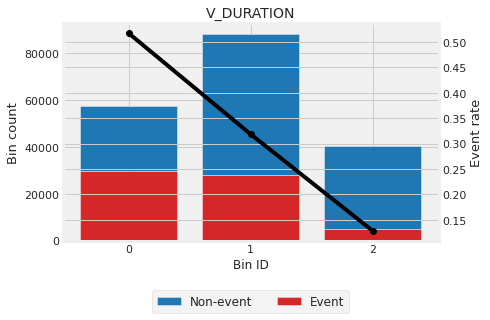

In [46]:
optb.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

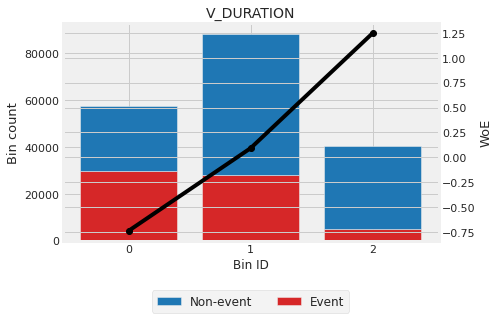

In [47]:
optb.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [48]:
opt_vl = binning_process.get_binned_variable("L_EF_VL_COUNT")
opt_vl.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.00)  119991   0.642594      70178  49813    0.415139   
1       [0.00, 2.50)   56061   0.300227      43816  12245    0.218423   
2        [2.50, inf)   10677   0.057179       9475   1202    0.112578   
3            Special       0   0.000000          0      0    0.000000   
4            Missing       0   0.000000          0      0    0.000000   
Totals                186729   1.000000     123469  63260    0.338780   

             WoE        IV        JS  
0      -0.325978  0.071405  0.008886  
1       0.606144  0.097776  0.012038  
2       1.395933  0.080600  0.009329  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.249780  0.030254

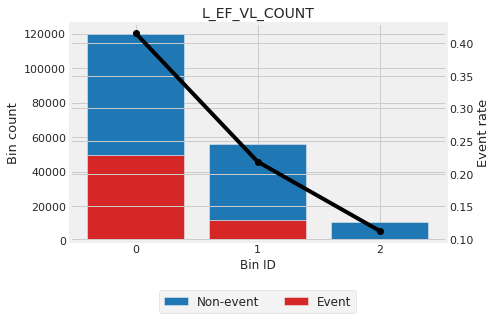

In [49]:
opt_vl.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

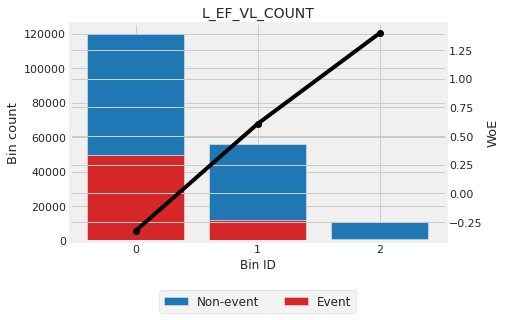

In [50]:
opt_vl.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [51]:
opt_age = binning_process.get_binned_variable("P_EF_CURRENT_AGE")
opt_age.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 27.50)   53171   0.284750      34442  18729    0.352241   
1       [27.50, 34.50)   47060   0.252023      31059  16001    0.340013   
2         [34.50, inf)   86498   0.463227      57968  28530    0.329834   
3              Special       0   0.000000          0      0    0.000000   
4              Missing       0   0.000000          0      0    0.000000   
Totals                  186729   1.000000     123469  63260    0.338780   

             WoE        IV            JS  
0      -0.059533  0.001019  1.273173e-04  
1      -0.005499  0.000008  9.536283e-07  
2       0.040198  0.000744  9.294414e-05  
3            0.0  0.000000  0.000000e+00  
4            0.0  0.000000  0.000000e+00  
Totals            0.001770  2.212151e-04

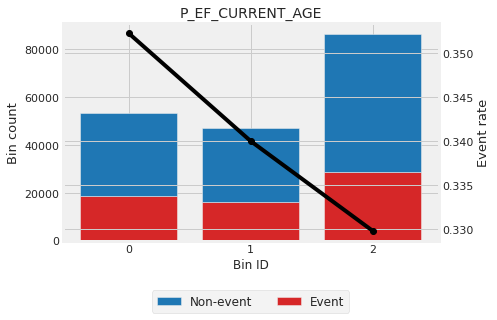

In [52]:
opt_age.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

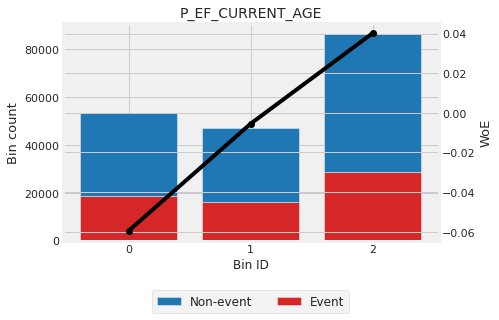

In [53]:
opt_age.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [54]:
opt_visits = binning_process.get_binned_variable("V_EF_VISITS_AT_THIS_FACILITY")
opt_visits.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 2.50)   57982   0.310514      30376  27606    0.476113   
1       [2.50, 8.50)   86904   0.465402      59677  27227    0.313300   
2        [8.50, inf)   41843   0.224084      33416   8427    0.201396   
3            Special       0   0.000000          0      0    0.000000   
4            Missing       0   0.000000          0      0    0.000000   
Totals                186729   1.000000     123469  63260    0.338780   

             WoE        IV        JS  
0      -0.573117  0.109103  0.013454  
1       0.116001  0.006141  0.000767  
2       0.708857  0.097419  0.011929  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.212663  0.026150

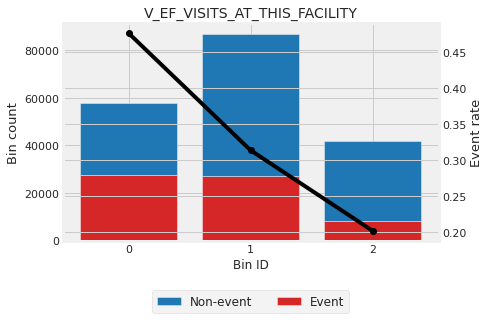

In [55]:
opt_visits.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

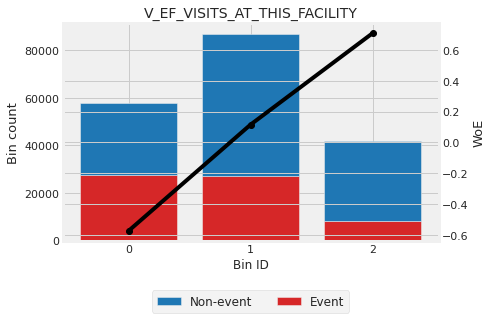

In [56]:
opt_visits.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [57]:
opt_time_int_treatment = binning_process.get_binned_variable("U_EF_MONTHS_SINCE_FIRST_VISIT")
opt_time_int_treatment.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0        (-inf, 1.50)   50019   0.267869      25648  24371    0.487235   
1       [1.50, 21.50)  108855   0.582957      74873  33982    0.312177   
2        [21.50, inf)   27855   0.149173      22948   4907    0.176162   
3             Special       0   0.000000          0      0    0.000000   
4             Missing       0   0.000000          0      0    0.000000   
Totals                 186729   1.000000     123469  63260    0.338780   

             WoE        IV        JS  
0      -0.617665  0.109650  0.013492  
1       0.121225  0.008393  0.001048  
2       0.873831  0.094629  0.011466  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.212671  0.026007

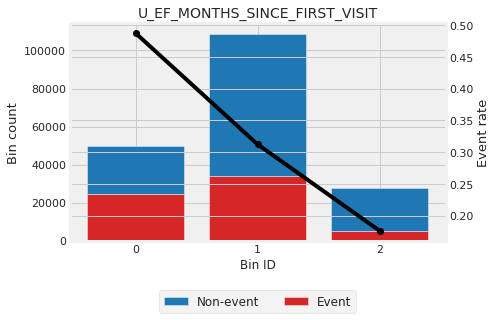

In [58]:
opt_time_int_treatment.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

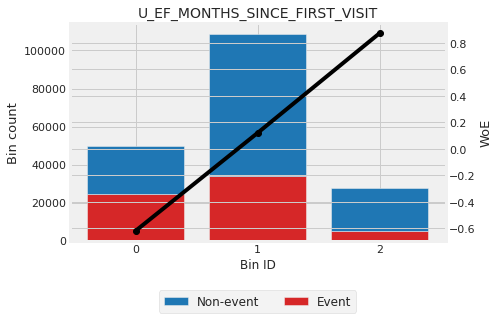

In [59]:
opt_time_int_treatment.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [60]:
opt_late_days_count = binning_process.get_binned_variable("V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS")
opt_late_days_count.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 0.50)   83379   0.446524      58929  24450    0.293239   
1       [0.50, 2.50)   66931   0.358439      43505  23426    0.350002   
2        [2.50, inf)   36419   0.195037      21035  15384    0.422417   
3            Special       0   0.000000          0      0    0.000000   
4            Missing       0   0.000000          0      0    0.000000   
Totals                186729   1.000000     123469  63260    0.338780   

             WoE        IV        JS  
0       0.210966  0.019151  0.002389  
1      -0.049708  0.000893  0.000112  
2      -0.355877  0.025915  0.003222  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.045959  0.005723

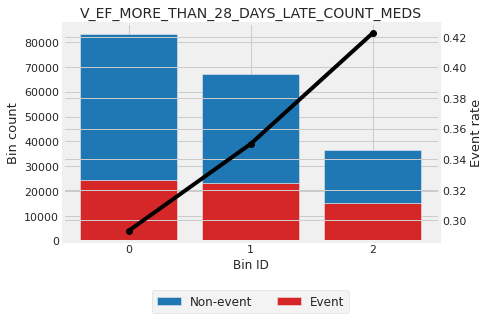

In [61]:
opt_late_days_count.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

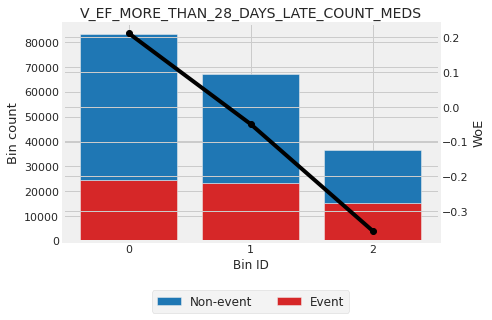

In [62]:
opt_late_days_count.binning_table.plot(metric="woe",add_missing = False, add_special = False)

In [63]:
opt_late_last = binning_process.get_binned_variable("V_EF_LATE_LAST_VISIT_MEDS")
opt_late_last.binning_table.build()

Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
0        [-1.0]   28991   0.155257      22121   6870    0.236970  0.500626   
1         [0.0]  101636   0.544297      65623  36013    0.354333 -0.068691   
2         [1.0]   56102   0.300446      35725  20377    0.363213 -0.107293   
3       Special       0   0.000000          0      0    0.000000       0.0   
4       Missing       0   0.000000          0      0    0.000000       0.0   
Totals           186729   1.000000     123469  63260    0.338780             

              IV        JS  
0       0.035326  0.004370  
1       0.002596  0.000324  
2       0.003516  0.000439  
3       0.000000  0.000000  
4       0.000000  0.000000  
Totals  0.041438  0.005134

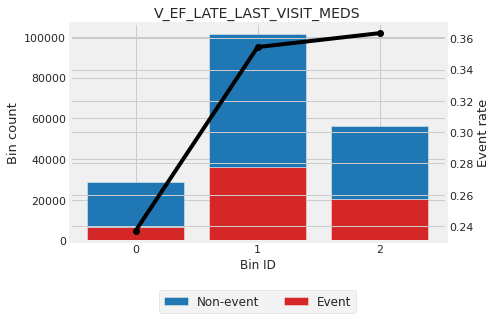

In [64]:
opt_late_last.binning_table.plot(metric="event_rate",add_missing = False, add_special = False)

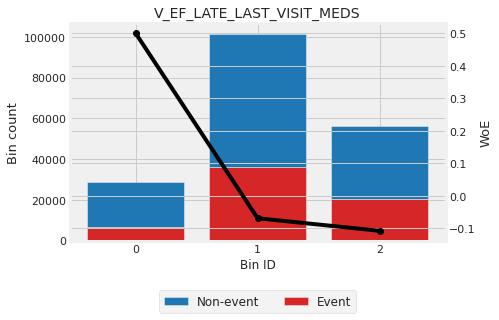

In [65]:
opt_late_last.binning_table.plot(metric="woe",add_missing = False, add_special = False)

## Points and Scoring

In [70]:
pd.set_option('display.max_rows',None)
scorecard.table(style="detailed").round(3)

Variable  Bin id              Bin   Count  \
0                              V_DURATION       0    (-inf, 49.50)   57741   
1                              V_DURATION       1  [49.50, 135.00)   88446   
2                              V_DURATION       2    [135.00, inf)   40542   
3                              V_DURATION       3          Special       0   
4                              V_DURATION       4          Missing       0   
0                           L_EF_VL_COUNT       0     (-inf, 0.00)  119991   
1                           L_EF_VL_COUNT       1     [0.00, 2.50)   56061   
2                           L_EF_VL_COUNT       2      [2.50, inf)   10677   
3                           L_EF_VL_COUNT       3          Special       0   
4                           L_EF_VL_COUNT       4          Missing       0   
0                        P_EF_CURRENT_AGE       0    (-inf, 27.50)   53171   
1                        P_EF_CURRENT_AGE       1   [27.50, 34.50)   47060   
2                        P_EF_CURRENT_AGE       2     [34.50, inf)   86498   
3                        P_EF_CURRENT_AGE       3          Special       0   
4                        P_EF_CURRENT_AGE       4          Missing       0   
0            V_EF_VISITS_AT_THIS_FACILITY       0     (-inf, 2.50)   57982   
1            V_EF_VISITS_AT_THIS_FACILITY       1     [2.50, 8.50)   86904   
2            V_EF_VISITS_AT_THIS_FACILITY       2      [8.50, inf)   41843   
3            V_EF_VISITS_AT_THIS_FACILITY       3          Special       0   
4            V_EF_VISITS_AT_THIS_FACILITY       4          Missing       0   
0           U_EF_MONTHS_SINCE_FIRST_VISIT       0     (-inf, 1.50)   50019   
1           U_EF_MONTHS_SINCE_FIRST_VISIT       1    [1.50, 21.50)  108855   
2           U_EF_MONTHS_SINCE_FIRST_VISIT       2     [21.50, inf)   27855   
3           U_EF_MONTHS_SINCE_FIRST_VISIT       3          Special       0   
4           U_EF_MONTHS_SINCE_FIRST_VISIT       4          Missing       0   
0               V_EF_LATE_LAST_VISIT_MEDS       0           [-1.0]   28991   
1               V_EF_LATE_LAST_VISIT_MEDS       1            [0.0]  101636   
2               V_EF_LATE_LAST_VISIT_MEDS       2            [1.0]   56102   
3               V_EF_LATE_LAST_VISIT_MEDS       3          Special       0   
4               V_EF_LATE_LAST_VISIT_MEDS       4          Missing       0   
0  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS       0     (-inf, 0.50)   83379   
1  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS       1     [0.50, 2.50)   66931   
2  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS       2      [2.50, inf)   36419   
3  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS       3          Special       0   
4  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS       4          Missing       0   

   Count (%)  Non-event  Event  Event rate    WoE     IV     JS  Coefficient  \
0      0.309      27862  29879       0.517 -0.739  0.182  0.022       -0.698   
1      0.474      60269  28177       0.319  0.092  0.004  0.000       -0.698   
2      0.217      35338   5204       0.128  1.247  0.254  0.030       -0.698   
3      0.000          0      0       0.000  0.000  0.000  0.000       -0.698   
4      0.000          0      0       0.000  0.000  0.000  0.000       -0.698   
0      0.643      70178  49813       0.415 -0.326  0.071  0.009       -0.352   
1      0.300      43816  12245       0.218  0.606  0.098  0.012       -0.352   
2      0.057       9475   1202       0.113  1.396  0.081  0.009       -0.352   
3      0.000          0      0       0.000  0.000  0.000  0.000       -0.352   
4      0.000          0      0       0.000  0.000  0.000  0.000       -0.352   
0      0.285      34442  18729       0.352 -0.060  0.001  0.000       -0.412   
1      0.252      31059  16001       0.340 -0.005  0.000  0.000       -0.412   
2      0.463      57968  28530       0.330  0.040  0.001  0.000       -0.412   
3      0.000          0      0       0.000  0.000  0.000  0.000       -0.412   
4      0.000          0 

In [71]:
test_new.loc[:,"score"] = scorecard.score(test_new)

/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [76]:
y_pred = scorecard.predict_proba(train_new)[:, 1]

In [77]:
score = scorecard.score(train_new)

In [78]:
logreg.fit(X_train,y_train)

/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=17.5)

In [79]:
y_pred_probs = logreg.predict_proba(X_test)[:, 1]
y_pred_bin = logreg.predict(X_test)
print(classification_report(y_test, y_pred_bin))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81     26915
           1       0.66      0.36      0.46     13708

    accuracy                           0.72     40623
   macro avg       0.70      0.63      0.64     40623
weighted avg       0.71      0.72      0.69     40623



Train set target distribution:
 123469 0.6612202710880474 
 63260 0.3387797289119526 

Test set target distribution:
 26915 0.66 
 13708 0.34 


Metrics:
  f1: 0.463
  MCC: 0.323
  accuracy: 0.721
  specificity: 0.907
  precision: 0.66
  recal: 0.357
  roc_auc: 0.749
  GINI: 0.499
  PR_AUC: 0.453
  Brier_loss: 0.186

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81     26915
           1       0.66      0.36      0.46     13708

    accuracy                           0.72     40623
   macro avg       0.70      0.63      0.64     40623
weighted avg       0.71      0.72      0.69     40623



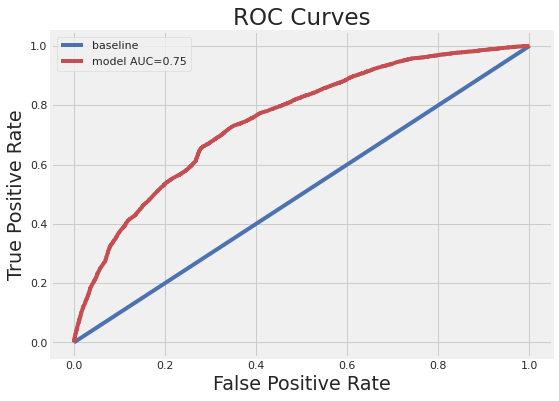

Precision Recall Curve
Precision Recall AUC = 0.453
Confusion matrix:
[[24400  2515]
 [ 8817  4891]]


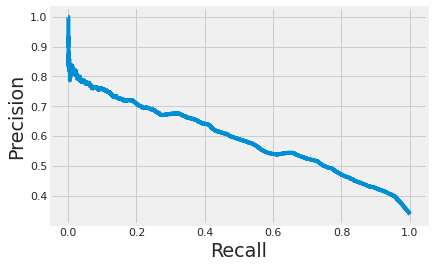

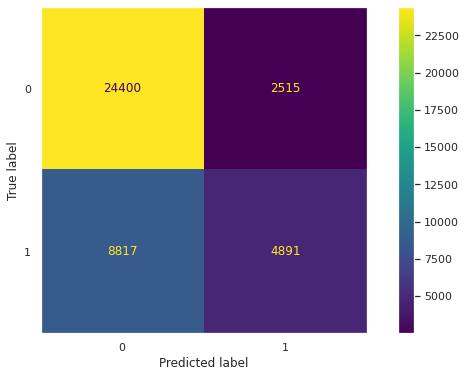

In [80]:
model_validation.evaluate_model(model=logreg, predictions=y_pred_bin, probs=y_pred_probs, y_train=y_train,
                                X_test=X_test, y_test=y_test)

## Score Analysis

[]

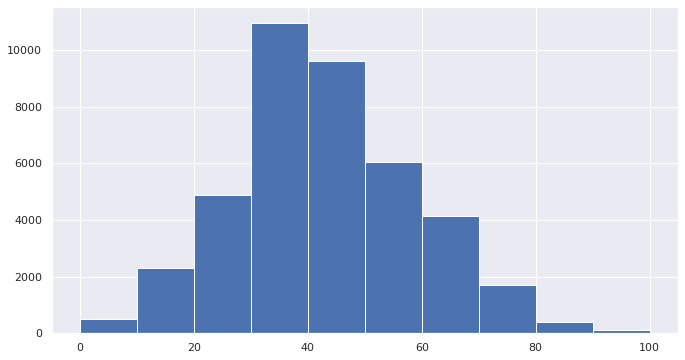

In [81]:
test_new['score'].hist().plot()

In [82]:
test_new['class'] = y_test 

/tmp/ipykernel_15300/3191510609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new['class'] = y_test


In [83]:
test_new['probs'] = y_pred_probs
test_new['pred'] = y_pred_bin

/tmp/ipykernel_15300/1101438757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new['probs'] = y_pred_probs
/tmp/ipykernel_15300/1101438757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new['pred'] = y_pred_bin


[]

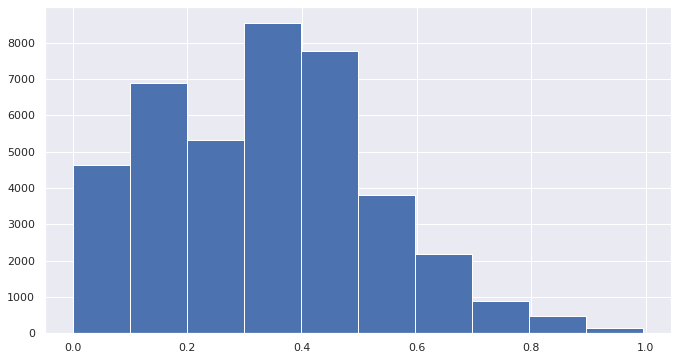

In [84]:
test_new['probs'].hist().plot()

In [86]:
test_new['class'] = test_new['class'].astype('category')

/tmp/ipykernel_15300/822503152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new['class'] = test_new['class'].astype('category')


<AxesSubplot:xlabel='score', ylabel='Count'>

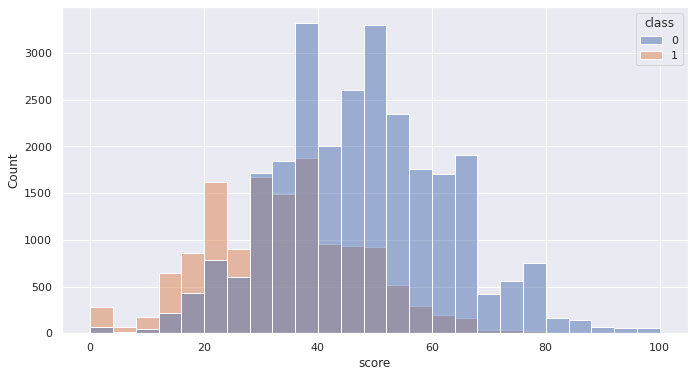

In [94]:
sns.histplot(data=test_new,x="score",hue="class",bins=25)

In [112]:
conditions = [((test_new['score'] >= -5) & (test_new['score'] <= 27)),((test_new['score'] > 27) & (test_new['score'] <= 42)),((test_new['score'] > 42) & (test_new['score'] <= 100))
             ]
choices = ['low','mid','high']
test_new['band'] = np.select(conditions, choices)

/tmp/ipykernel_15300/1514928573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_new['band'] = np.select(conditions, choices)


In [113]:
test_new['band'].value_counts(normalize=True)

high    0.515176
mid     0.338158
low     0.146666
Name: band, dtype: float64

In [114]:
# Check LTFU rates
round(100*test_new.groupby(['band'])['class'].value_counts(normalize=True),2)

band  class
high  0        82.20
      1        17.80
low   1        68.68
      0        31.32
mid   0        57.12
      1        42.88
Name: class, dtype: float64

### PSI check

In [119]:
monitoring = ScorecardMonitoring(scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=3, verbose=True)

In [120]:
monitoring.fit(X_test, y_test, X_train, y_train)

2022-02-10 08:56:03,149 | INFO : Monitoring started.
2022-02-10 08:56:03,150 | INFO : Options: check parameters.
2022-02-10 08:56:03,156 | INFO : System stability analysis started.
2022-02-10 08:56:03,626 | INFO : System stability analysis terminated. Time: 0.4694s
2022-02-10 08:56:03,627 | INFO : Variable analysis started.
2022-02-10 08:56:03,693 | INFO : Variable analysis terminated. Time: 0.0655s
2022-02-10 08:56:03,694 | INFO : Monitoring terminated. Time: 0.5450s


ScorecardMonitoring(psi_n_bins=3,
                    scorecard=Scorecard(binning_process=BinningProcess(categorical_variables=['L_COMMENT',
                                                                                              'P_EF_IS_MALE',
                                                                                              'V_EF_LATE_LAST_VISIT_MEDS',
                                                                                              'V_EF_WAS_MORE_THAN_28_DAYS_LATE_MEDS',
                                                                                              'L_T_VL_SUPP_1000',
                                                                                              'L_T_RISE_VL_CATEGORIZATION',
                                                                                              'V_EF_LATE_THIS_VISIT_MEDS'],
                                                                       max_n_bins=3,
                                             

In [121]:
monitoring.information(print_level=2)

optbinning (Version 0.13.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                             3   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                             True   * U
  End options

  Statistics
    Number of records Actual           40623
    Number of records Expected        186729
    Number of scorecard variables          7
    Target type                       binary

  Timing
    Total time                          0.54 sec
    System stability                    0.47 sec   ( 86.13%)
    Variables stability                 0.07 sec   ( 12.02%)



In [122]:
monitoring.psi_table()

Bin  Count A  Count E  Count A (%)  Count E (%)       PSI
0        (-inf, 36.16)    13454    61554     0.331192     0.329643  0.000007
1       [36.16, 48.01)    11704    53661     0.288113     0.287374  0.000002
2         [48.01, inf)    15465    71514     0.380696     0.382983  0.000014
Totals                    40623   186729     1.000000     1.000000  0.000023

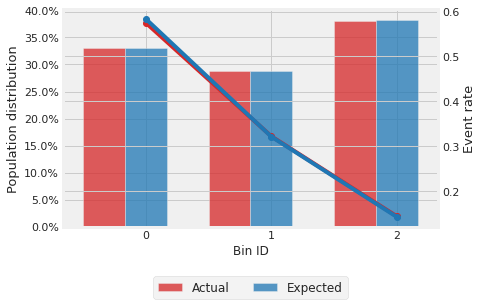

In [123]:
monitoring.psi_plot()

In [124]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0000 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      3        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0   0.000000
    [0.05, 0.10)      1   0.333333
    [0.10, 0.50)      0   0.000000
    [0.50, 1.00)      2   0.666667

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records   40623          -    186729            -
        Event records   13708   0.337444     63260      0.33878
    Non-event records   26915   0.662556    123469      0.66122

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.395317  0.396412   -0.001095
     True negative rate 0.885

In [125]:
monitoring.psi_variable_table(style="detailed")

Variable              Bin  Count A  Count E  \
0                              V_DURATION    (-inf, 49.50)    12414    57741   
1                              V_DURATION  [49.50, 135.00)    19439    88446   
2                              V_DURATION    [135.00, inf)     8770    40542   
0                           L_EF_VL_COUNT     (-inf, 0.00)    26284   119991   
1                           L_EF_VL_COUNT     [0.00, 2.50)    12078    56061   
2                           L_EF_VL_COUNT      [2.50, inf)     2261    10677   
0                        P_EF_CURRENT_AGE    (-inf, 27.50)    11684    53171   
1                        P_EF_CURRENT_AGE   [27.50, 34.50)    10590    47060   
2                        P_EF_CURRENT_AGE     [34.50, inf)    18349    86498   
0            V_EF_VISITS_AT_THIS_FACILITY     (-inf, 2.50)    12848    57982   
1            V_EF_VISITS_AT_THIS_FACILITY     [2.50, 8.50)    18995    86904   
2            V_EF_VISITS_AT_THIS_FACILITY      [8.50, inf)     8780    41843   
0           U_EF_MONTHS_SINCE_FIRST_VISIT     (-inf, 1.50)    11129    50019   
1           U_EF_MONTHS_SINCE_FIRST_VISIT    [1.50, 21.50)    23666   108855   
2           U_EF_MONTHS_SINCE_FIRST_VISIT     [21.50, inf)     5828    27855   
0               V_EF_LATE_LAST_VISIT_MEDS           [-1.0]     6424    28991   
1               V_EF_LATE_LAST_VISIT_MEDS            [0.0]    22182   101636   
2               V_EF_LATE_LAST_VISIT_MEDS            [1.0]    12017    56102   
0  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS     (-inf, 0.50)    18513    83379   
1  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS     [0.50, 2.50)    14549    66931   
2  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS      [2.50, inf)     7561    36419   

   Count A (%)  Count E (%)           PSI  
0     0.305590     0.309224  4.293837e-05  
1     0.478522     0.473660  4.965957e-05  
2     0.215888     0.217117  6.979225e-06  
0     0.647023     0.642594  3.041166e-05  
1     0.297319     0.300227  2.829017e-05  
2     0.055658     0.057179  4.100718e-05  
0     0.287620     0.284750  2.879716e-05  
1     0.260690     0.252023  2.930299e-04  
2     0.451690     0.463227  2.910025e-04  
0     0.316274     0.310514  1.058634e-04  
1     0.467592     0.465402  1.028599e-05  
2     0.216134     0.224084  2.872008e-04  
0     0.273958     0.267869  1.368439e-04  
1     0.582576     0.582957  2.487583e-07  
2     0.143466     0.149173  2.226907e-04  
0     0.158137     0.155257  5.293171e-05  
1     0.546045     0.544297  5.608065e-06  
2     0.295818     0.300446  7.185773e-05  
0     0.455727     0.446524  1.877462e-04  
1     0.358147     0.358439  2.385809e-07  
2     0.186126     0.195037  4.166868e-04

In [126]:
monitoring.psi_variable_table(style="summary")

Variable       PSI
0                           L_EF_VL_COUNT  0.000100
1                        P_EF_CURRENT_AGE  0.000613
2           U_EF_MONTHS_SINCE_FIRST_VISIT  0.000360
3                              V_DURATION  0.000100
4               V_EF_LATE_LAST_VISIT_MEDS  0.000130
5  V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS  0.000605
6            V_EF_VISITS_AT_THIS_FACILITY  0.000403